import sys, importlib
importlib.reload(sys.modules['classic_CV_predict'])

In [4]:
import sys
sys.path.insert(0, "..")


from sf_runoff import daily_climatology, spatial_avg_daily_input, spatial_stats_daily_input, compute_anomalies, create_it_matrix
from nested_CV import SVR_nested_CV_gridsearch, SVR_PCA_nested_CV_gridsearch
from test import evaluate_prediction, plot_prediction, plot_anomalies
from test import nested_CV_PCA_SVR_predict, nested_CV_SVR_predict
from classic_CV_predict import classic_CV_PCA_SVR_predict, classic_CV_SVR_predict


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA


import matplotlib.pyplot as plt
import os
import pdb
import seaborn as sns

## A) ALL_VARS, T_UNIT = 30

In [52]:
path=r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\Documents\conda\daily_input\\'

daily_input = pd.read_csv(path+'KORONEMBURG_DONAU.txt', index_col=0, parse_dates=True)

daily_input_stat = spatial_stats_daily_input(daily_input)
#daily_input_stat=daily_input_stat[daily_input_stat.index.dayofyear%2==1]

t_unit=30


#define the possible parameters value (where Gridsearch is applied)

C_range=np.logspace(-1.5, 1.5, 10)
epsilon_range=np.logspace(-5, -2, 5)

#do not enlarge t_range for now
t_range=[12]
t_length=t_range[0]
n_splits=5
test_size=365


Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits

C3=0.31622776601683794
eps3=5.623413251903491e-05


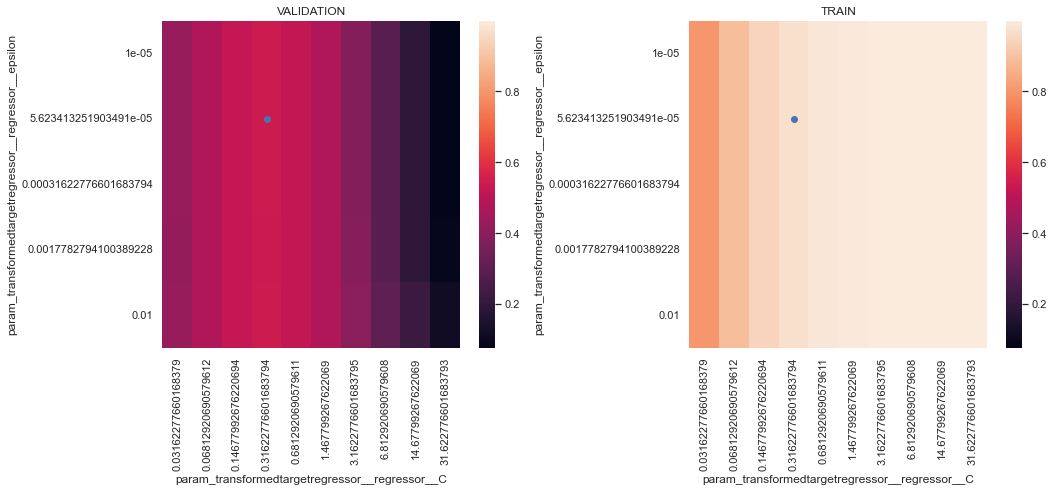

In [53]:
C, eps = SVR_nested_CV_gridsearch(daily_input_stat, C_range,epsilon_range, t_range,t_unit,n_splits,test_size)
print(f'C3={C}')
print(f'eps3={eps}') 

### PREDICT RUNOFF ON TEST SET AND QUANTIFY THE PERFORMANCE

In [54]:
radius_for_ensemble = 1
predictions = nested_CV_SVR_predict(daily_input_stat, C, eps, t_length,t_unit, n_splits, test_size, radius_for_ensemble)

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

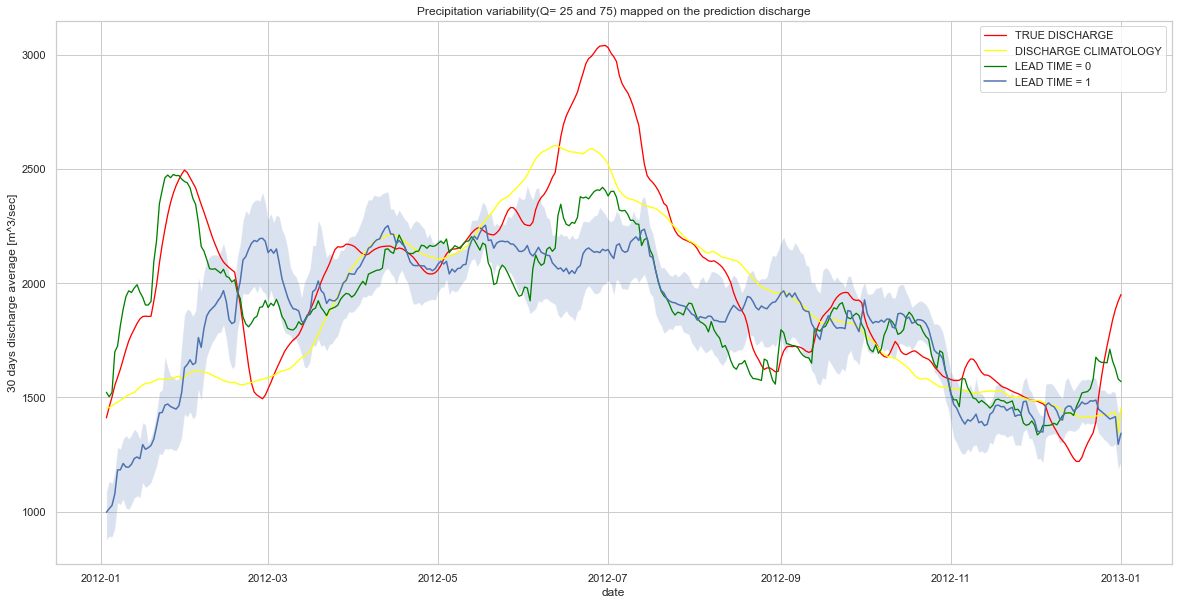

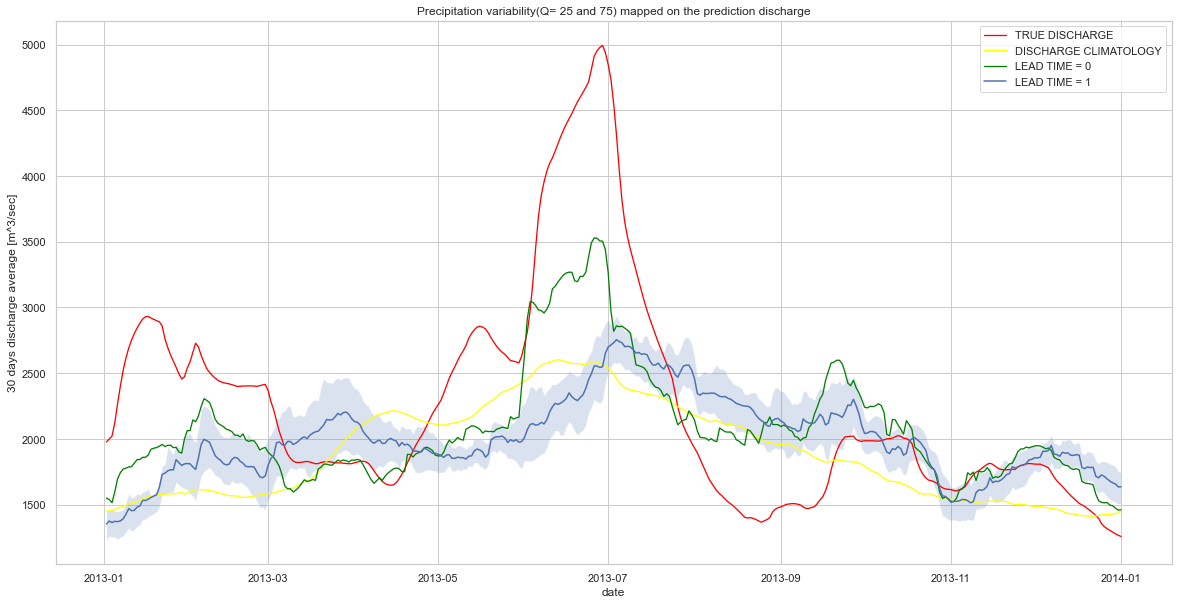

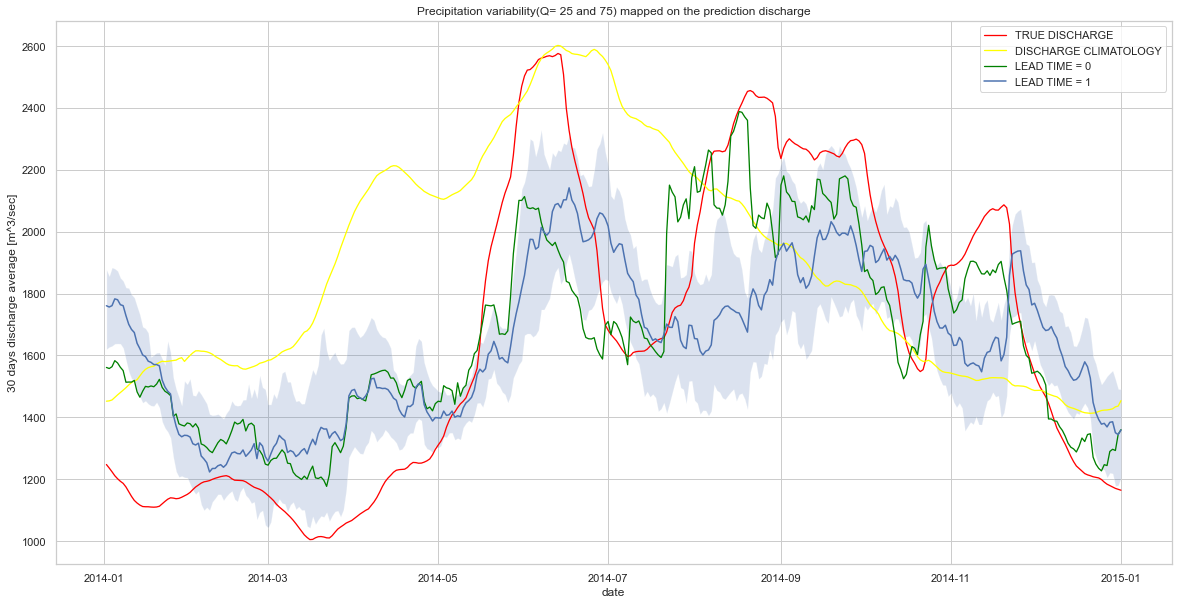

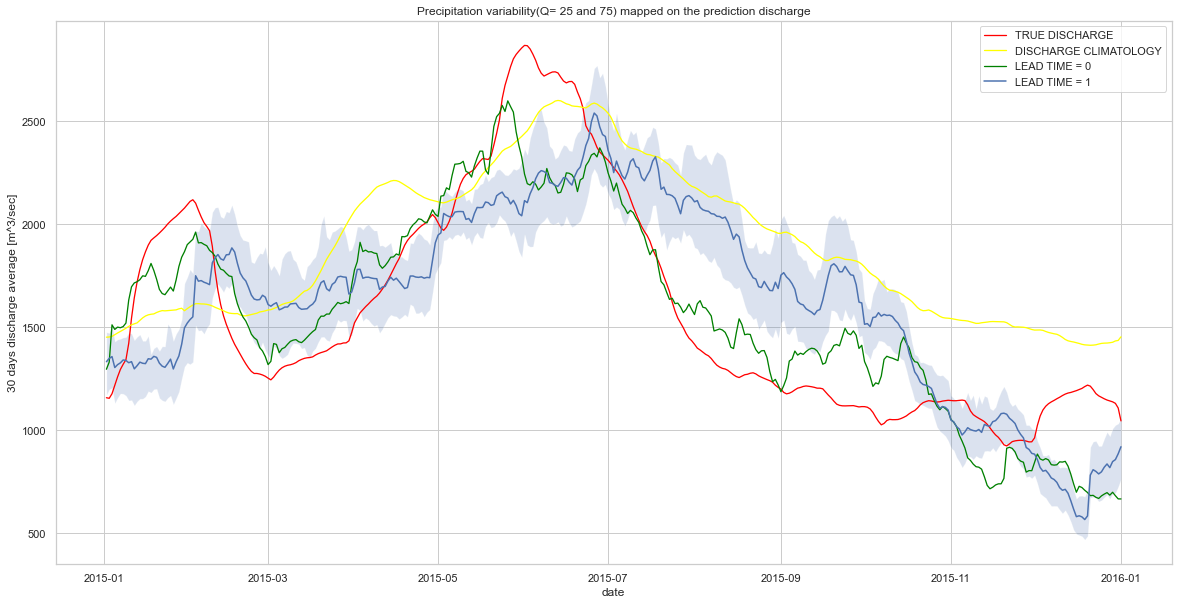

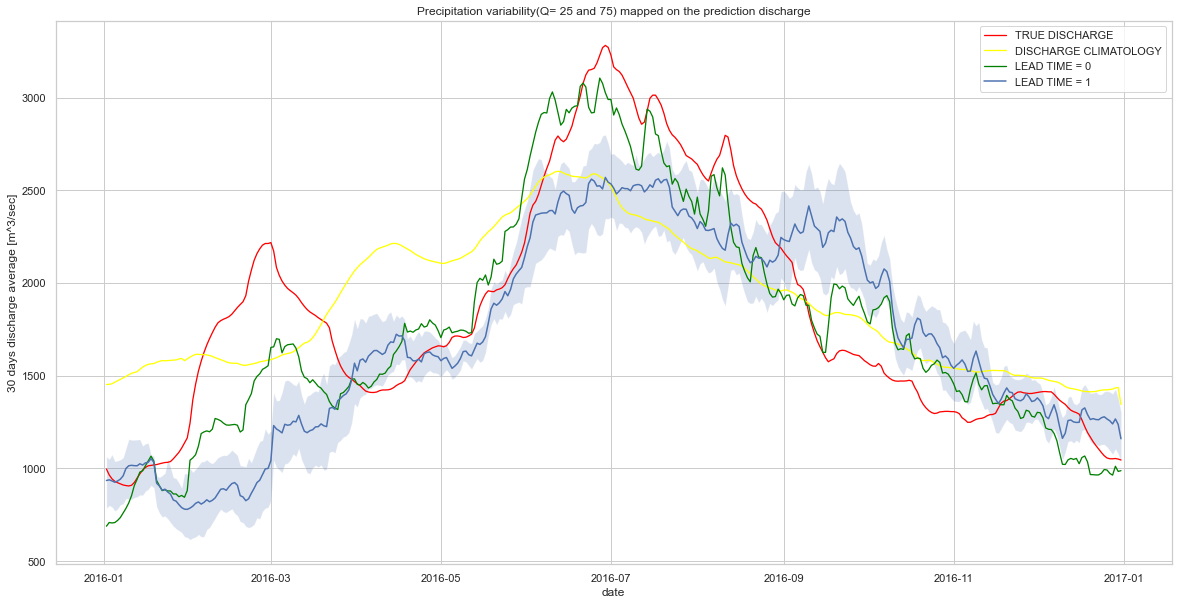

In [55]:
#predictions=pd.read_csv('tial.csv',date_parser=True)
plot_prediction(predictions)

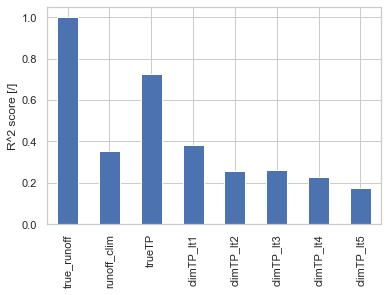

In [56]:
r2_A= evaluate_prediction(predictions)

### ANALYSE RESULTS AS ANOMALIES

### 1) PREDICT THE WHOLE SERIES WITH CLASSIC CV

In [57]:
predictions_for_clim = classic_CV_SVR_predict(daily_input_stat, C, eps, t_length,t_unit, n_splits)

In [58]:
climatologies =predictions_for_clim.groupby(by=predictions_for_clim.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies['doty']=climatologies.index


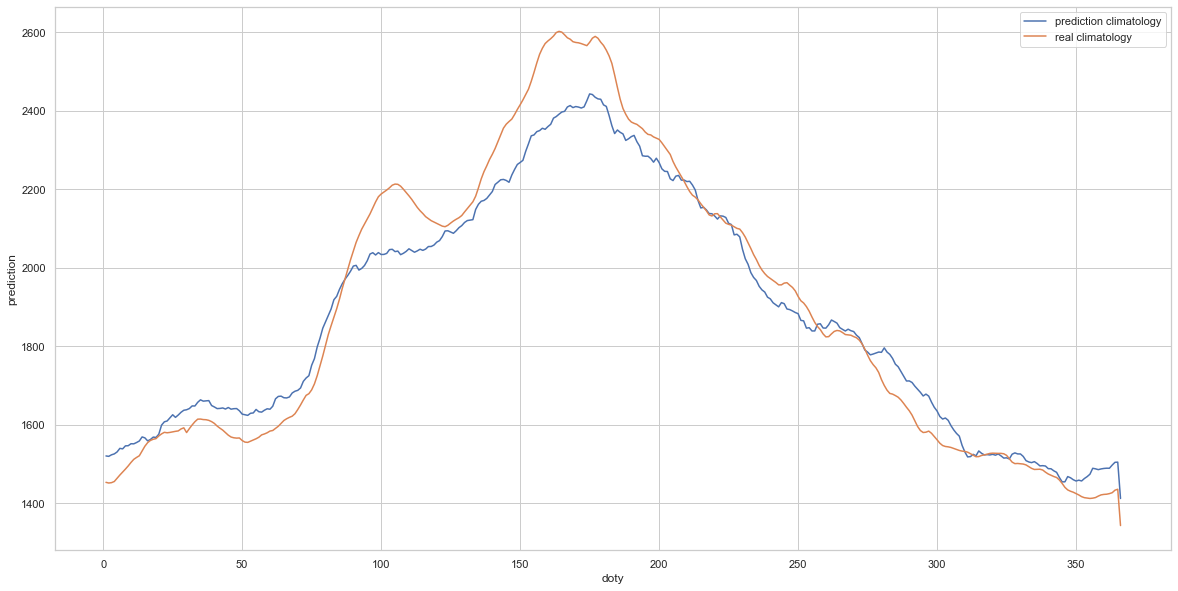

In [59]:
sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies,x='doty',y='true_runoff',label='real climatology')
plt.legend()

### 2) COMPUTE THE ANOMALIES AND PLOT THEM

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

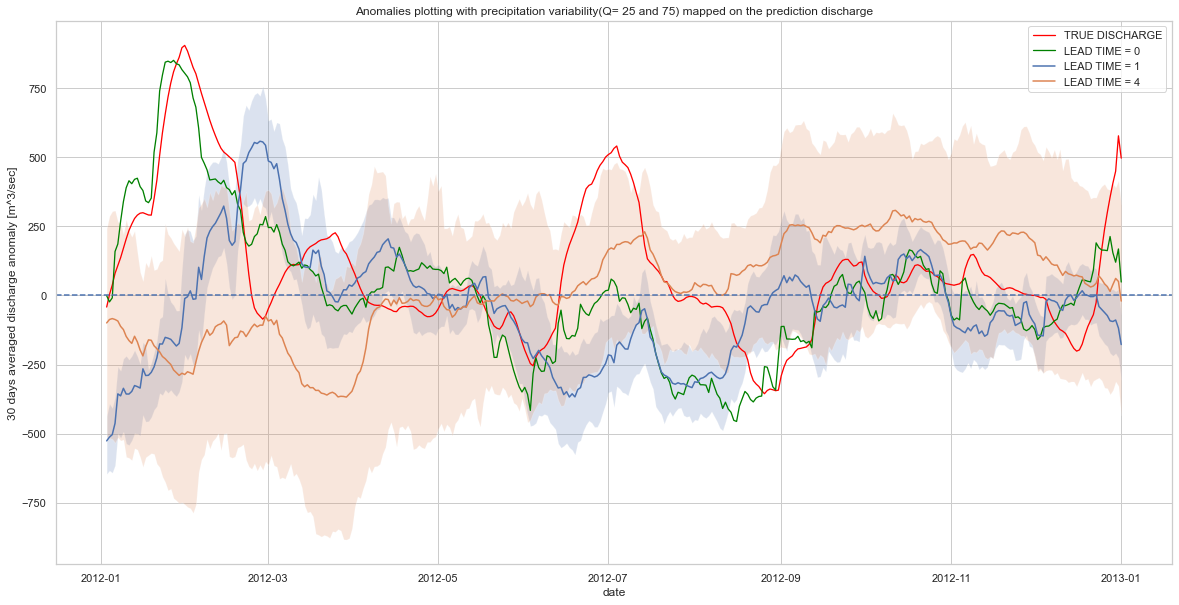

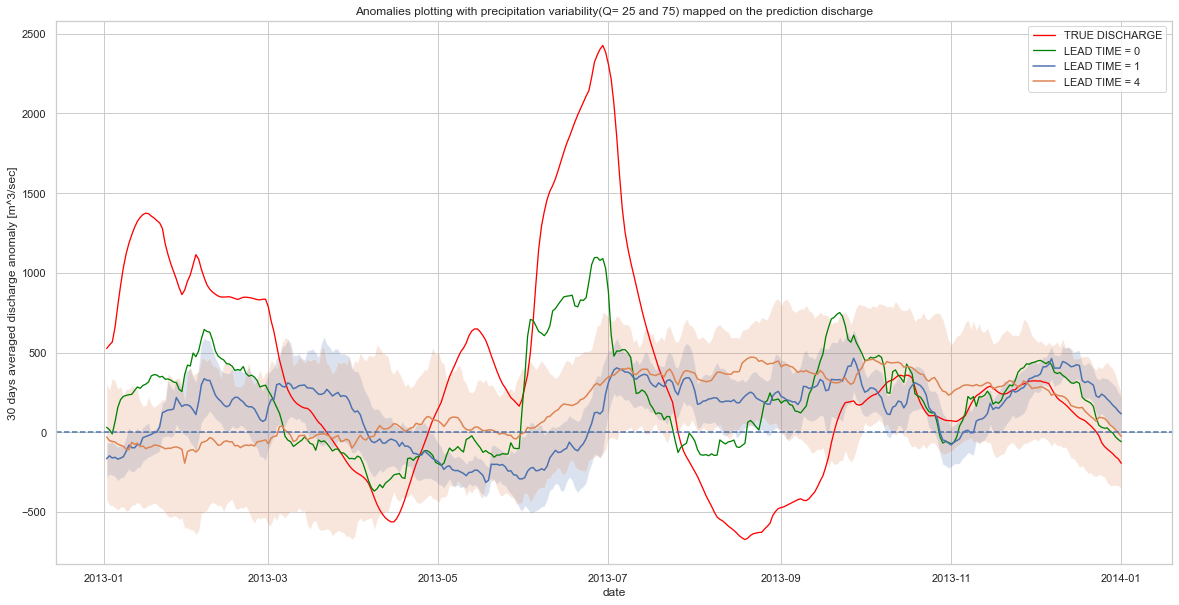

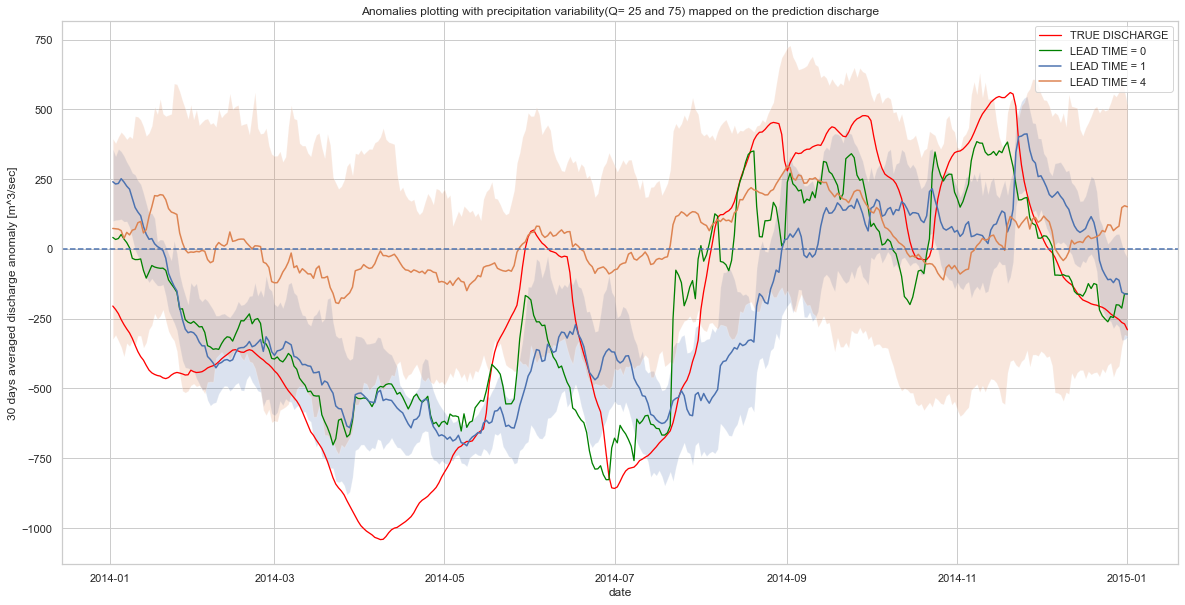

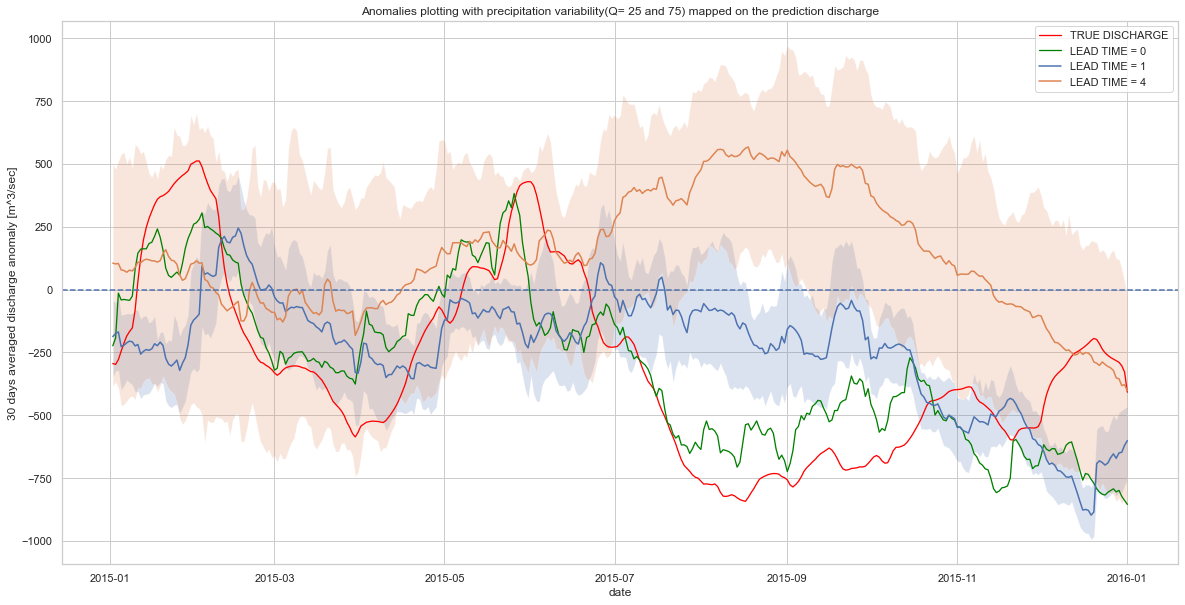

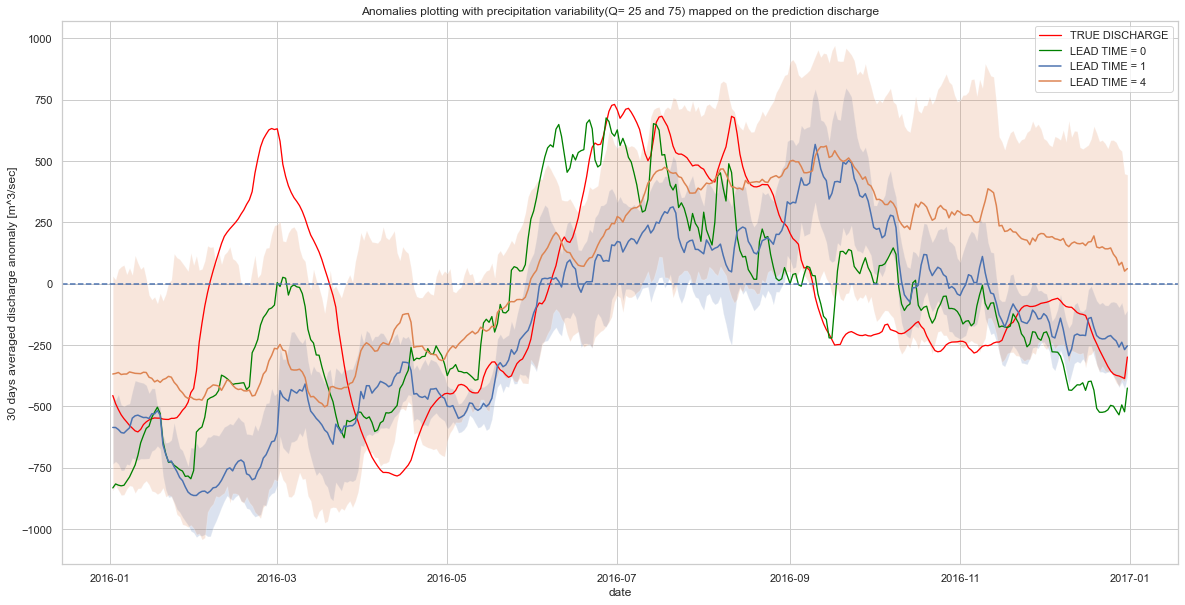

In [60]:
a=compute_anomalies(climatologies, predictions)
a['split']=predictions.split

plot_anomalies(a)

In [61]:
daily_input_stat.drop(columns=[c for c in daily_input_stat.columns if c[0]=='S'])

Q           T          T5         T25         T75  \
1995-01-01     NaN  272.065353  264.739328  271.034515  274.005036   
1995-01-02     NaN  268.985390  259.077335  268.202147  271.326517   
1995-01-03     NaN  268.005290  259.178228  267.695253  269.989324   
1995-01-04     NaN  264.356757  255.153289  263.943694  266.375944   
1995-01-05     NaN  261.886108  253.340368  260.874834  264.270641   
...            ...         ...         ...         ...         ...   
2016-12-28  1187.0  273.786933  268.069872  272.595881  275.665571   
2016-12-29  1226.0  271.397660  266.472835  270.578683  273.115503   
2016-12-30  1113.0  269.202868  265.013406  268.765826  270.116764   
2016-12-31  1009.0  268.577114  265.179142  267.707529  269.776373   
2017-01-01     NaN  268.328717  264.185065  267.335906  269.825687   

                   T95         E        E5       E25       E75       E95  \
1995-01-01  274.499972  0.021697 -0.126891 -0.053553  0.070834  0.241598   
1995-01-02  272.409698  0.148174 -0.002828  0.066347  0.211431  0.378468   
1995-01-03  270.984115  0.101230 -0.032795  0.025360  0.167721  0.262755   
1995-01-04  267.620663  0.019056 -0.101253 -0.049483  0.076984  0.167980   
1995-01-05  266.156328 -0.052813 -0.179694 -0.126003  0.010490  0.107779   
...                ...       ...       ...       ...       ...       ...   
2016-12-28  276.377199  0.241541 -0.117612  0.114811  0.348651  0.626115   
2016-12-29  273.763220 -0.118216 -0.284550 -0.169192 -0.079428  0.057506   
2016-12-30  272.033297 -0.160902 -0.415151 -0.306880 -0.073274  0.302948   
2016-12-31  271.783351 -0.050706 -0.275274 -0.159910  0.017243  0.300069   
2017-01-01  271.602840  0.018451 -0.277040 -0.149784  0.162990  0.438580   

                   P        P5           P25       P75        P95  
1995-01-01  3.022747  0.401142  1.626908e+00  3.974867   6.914494  
1995-01-02  3.008486  0.234397  1.573116e+00  4.077230   6.903528  
1995-01-03  5.302923  1.641913  3.632859e+00  6.617021  10.716520  
1995-01-04  2.150922  0.157461  3.086729e-01  3.259732   7.391879  
1995-01-05  0.152065  0.006031  4.221236e-02  0.196233   0.504162  
...              ...       ...           ...       ...        ...  
2016-12-28  2.730421  0.000770  2.390905e-02  4.480620  11.331523  
2016-12-29  3.342623  0.000110  1.015684e-02  3.493096  18.044790  
2016-12-30  0.005998 -0.000006  0.000000e+00  0.002222   0.032496  
2016-12-31  0.000014 -0.000009 -2.000140e-07  0.000004   0.000061  
2017-01-01  0.000135 -0.000006  0.000000e+00  0.000010   0.000368  

[8037 rows x 16 columns]

## B) NO_SNOW, T_UNIT = 30

In [62]:
daily_input_stat2 = daily_input_stat.drop(columns=[c for c in daily_input_stat.columns if c[0]=='S'])


In [63]:
#define the possible parameters value (where Gridsearch is applied)

C_range=np.logspace(-1.5, 1.5, 10)
epsilon_range=np.logspace(-5, -2, 5)


Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits

C2=0.14677992676220694
eps2=5.623413251903491e-05


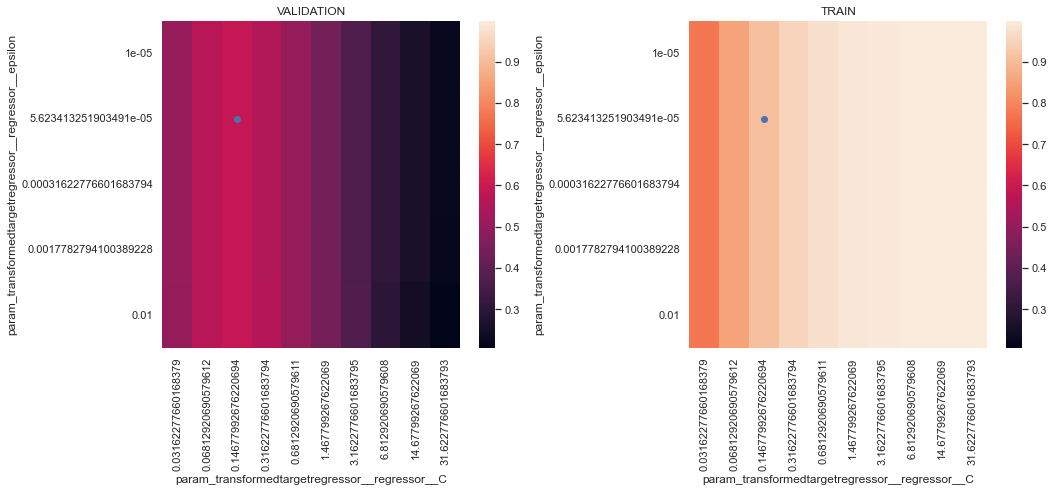

In [64]:
C2, eps2 = SVR_nested_CV_gridsearch(daily_input_stat2, C_range,epsilon_range, t_range,t_unit,n_splits,test_size)
print(f'C2={C2}')
print(f'eps2={eps2}')

### PREDICT RUNOFF ON TEST SET AND QUANTIFY THE PERFORMANCE

In [65]:
radius_for_ensemble = 1
predictions2 = nested_CV_SVR_predict(daily_input_stat2, C2, eps2, t_length, t_unit, n_splits, test_size, radius_for_ensemble)

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

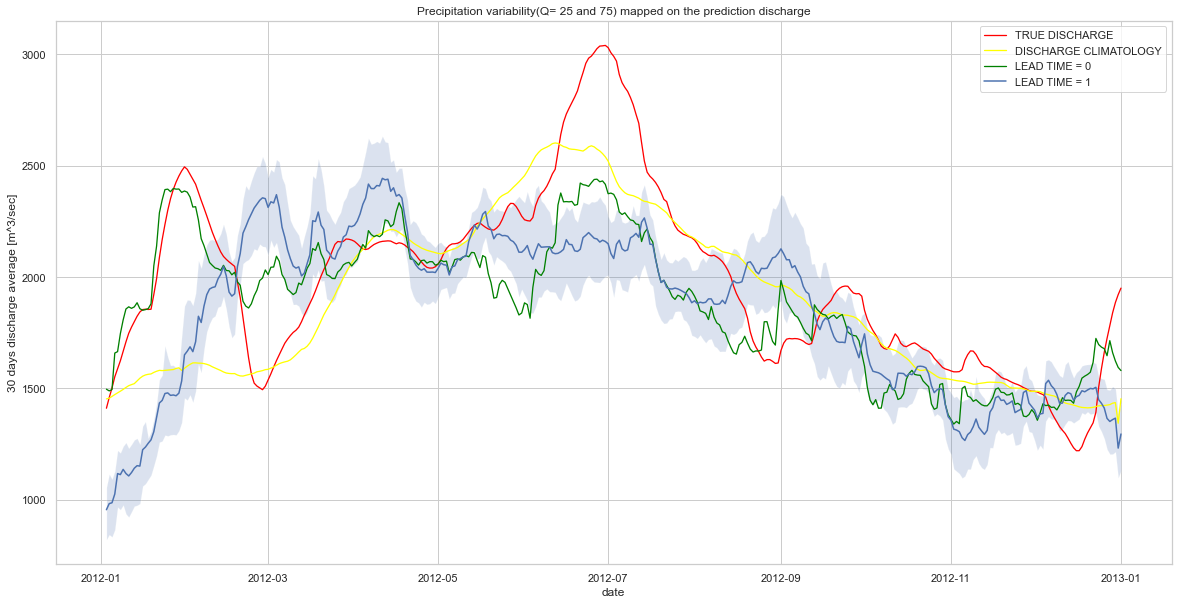

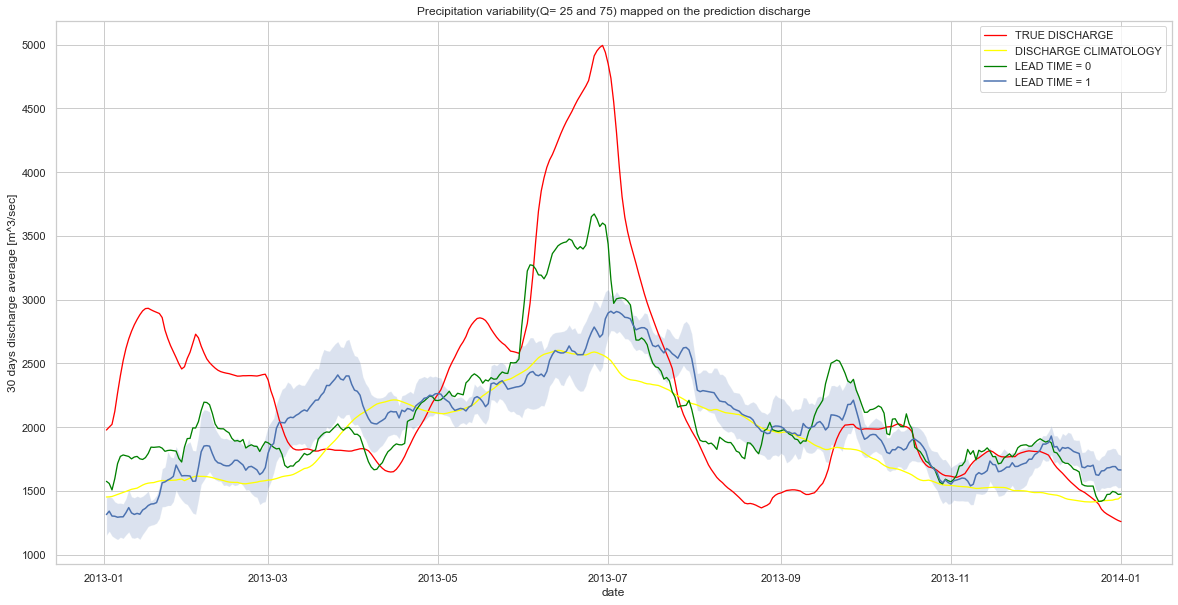

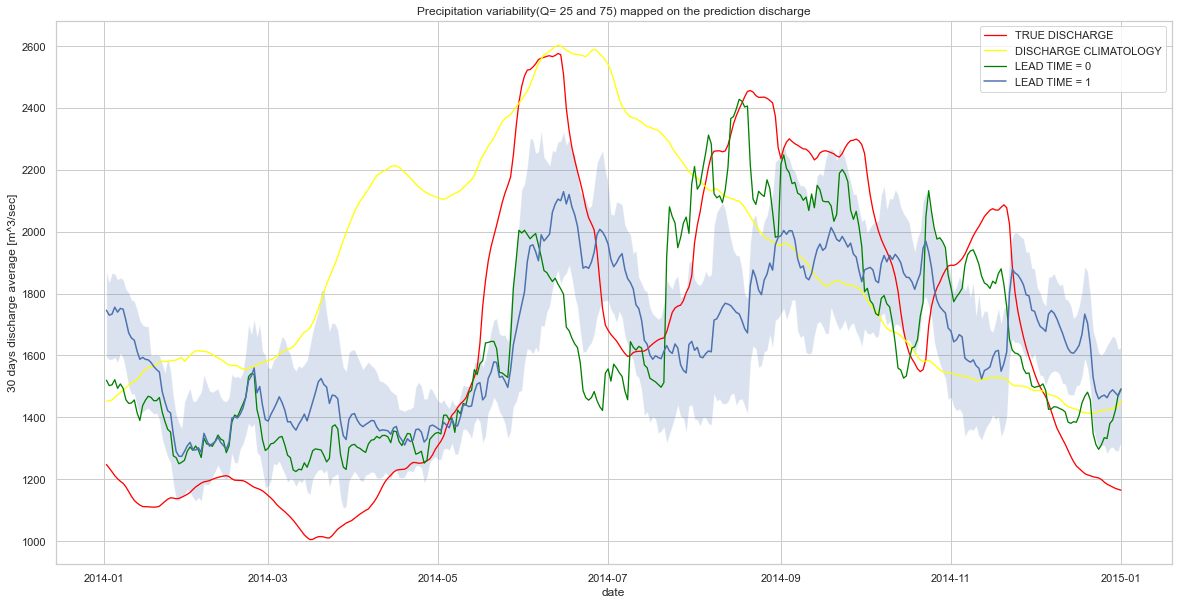

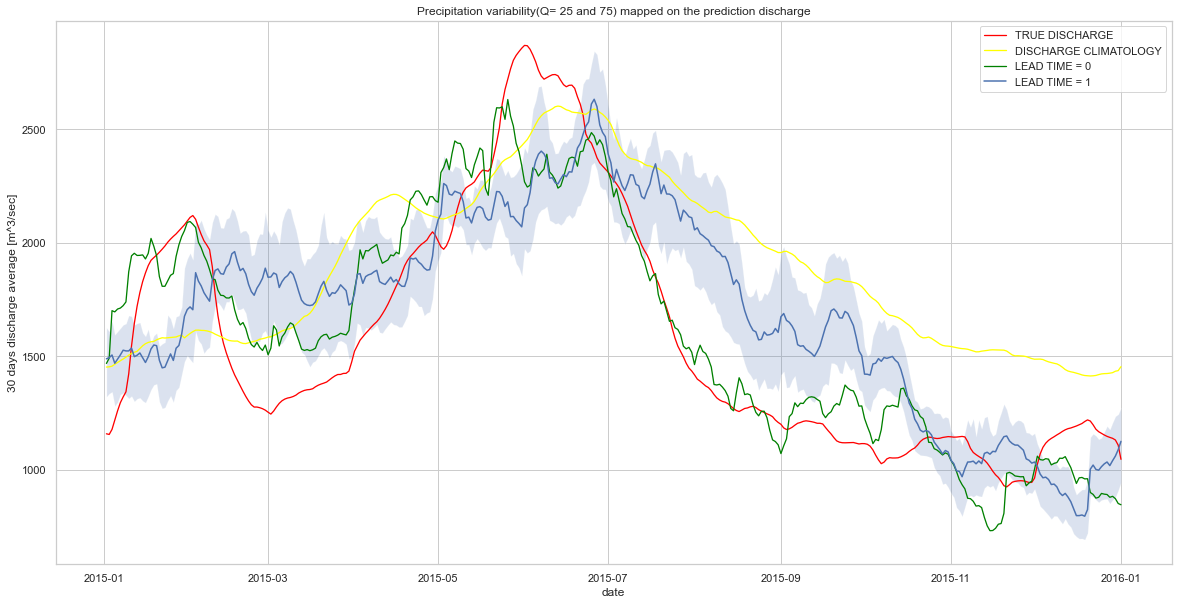

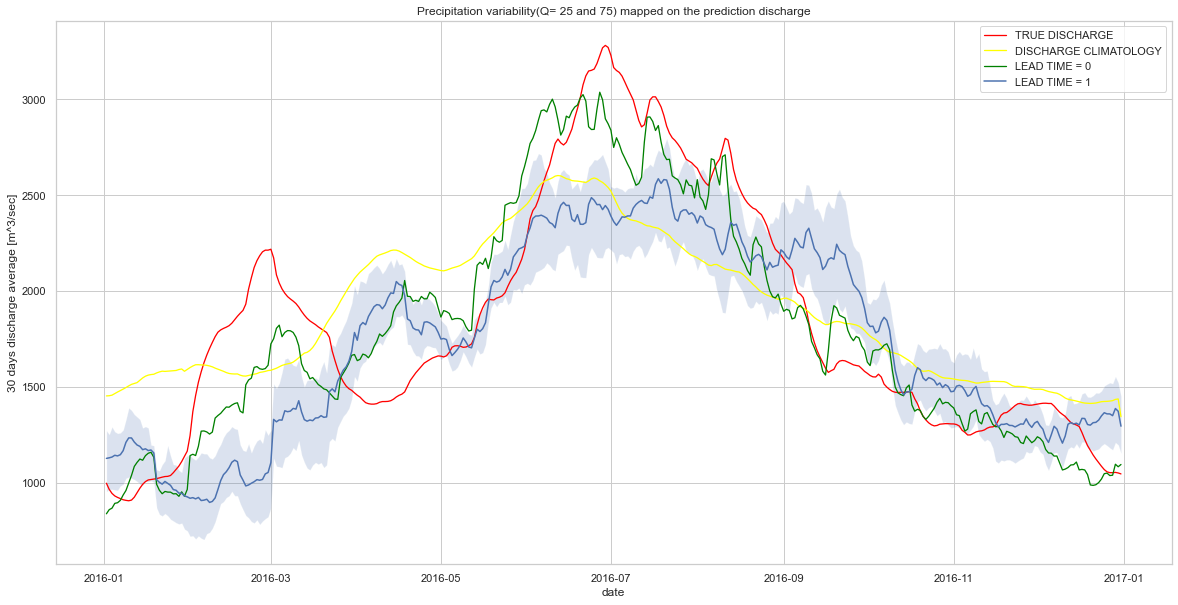

In [66]:
#predictions=pd.read_csv('tial.csv',date_parser=True)
plot_prediction(predictions2)

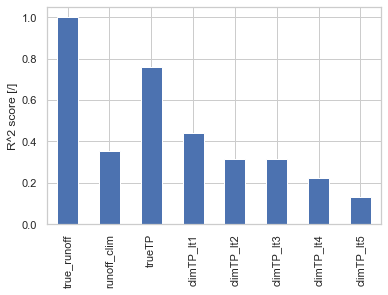

In [67]:
r2_B= evaluate_prediction(predictions2)

### ANALYSE RESULTS AS ANOMALIES

### 1) PREDICT THE WHOLE SERIES WITH CLASSIC CV

In [68]:
predictions_for_clim2 = classic_CV_SVR_predict(daily_input_stat2, C2, eps2, t_length, t_unit, n_splits)

In [69]:
climatologies2 =predictions_for_clim2.groupby(by=predictions_for_clim2.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies2['doty']=climatologies2.index


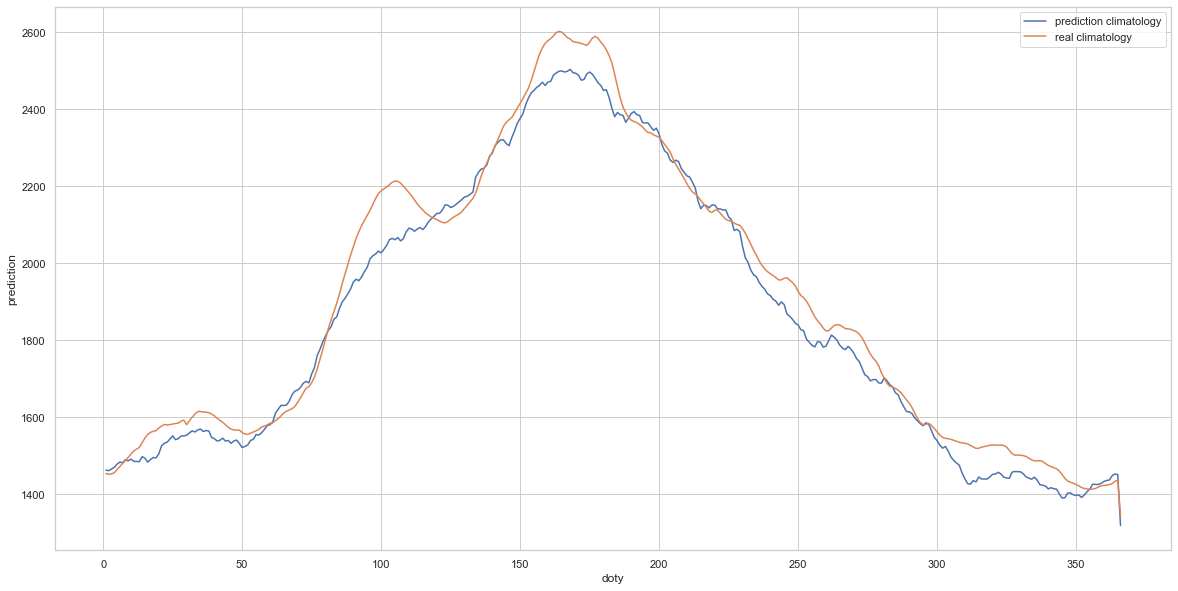

In [70]:
sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies2,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies2,x='doty',y='true_runoff',label='real climatology')
plt.legend()

### 2) COMPUTE THE ANOMALIES AND PLOT THEM

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

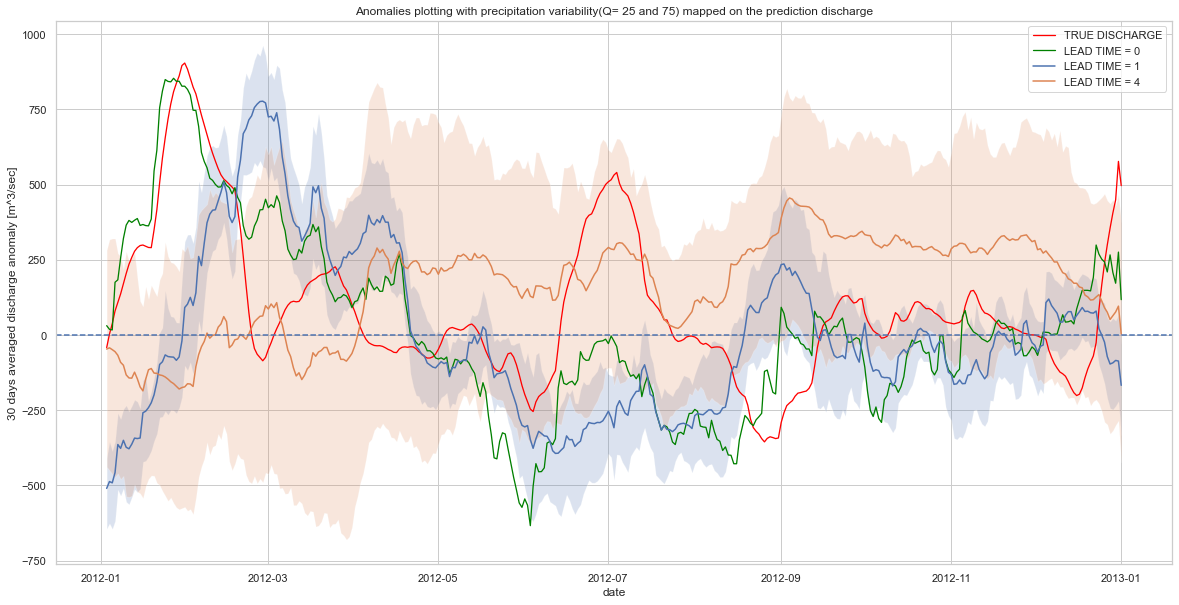

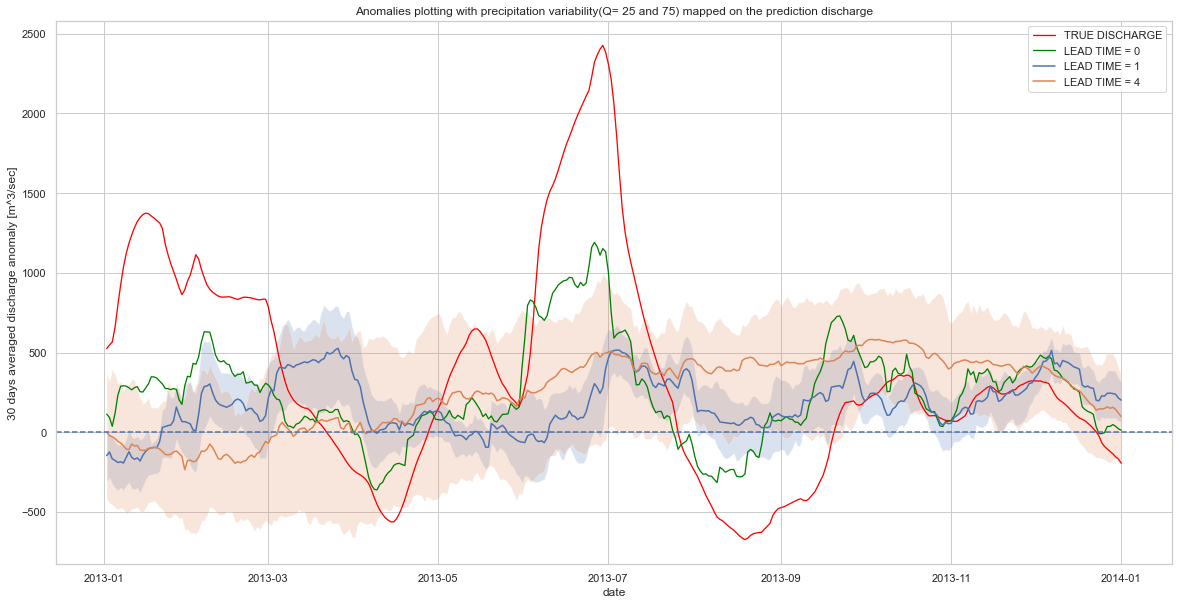

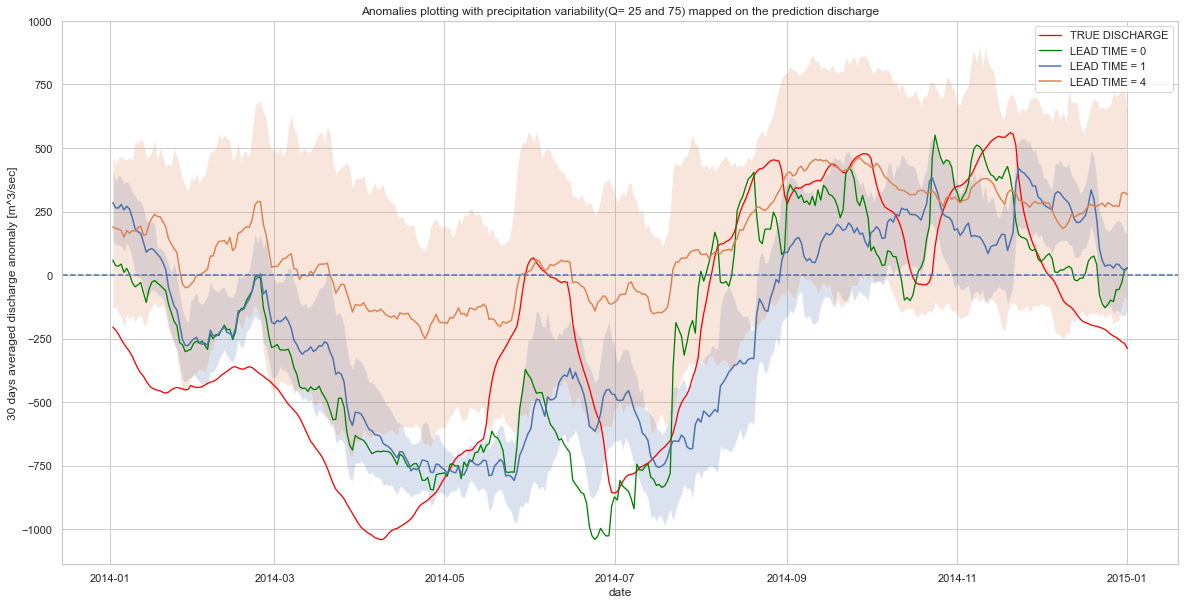

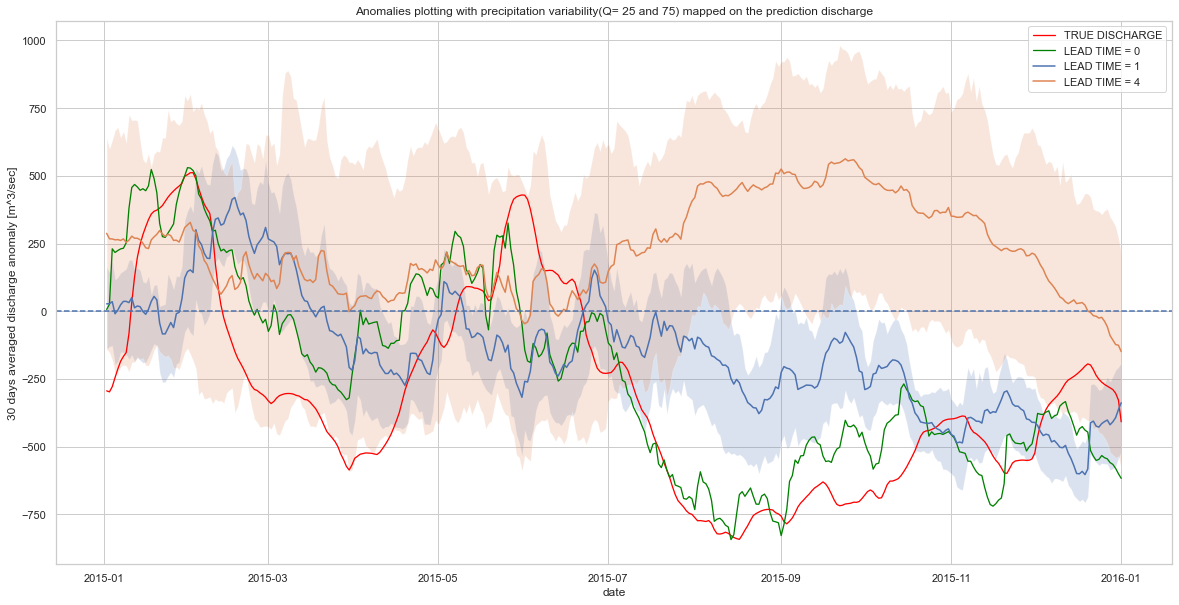

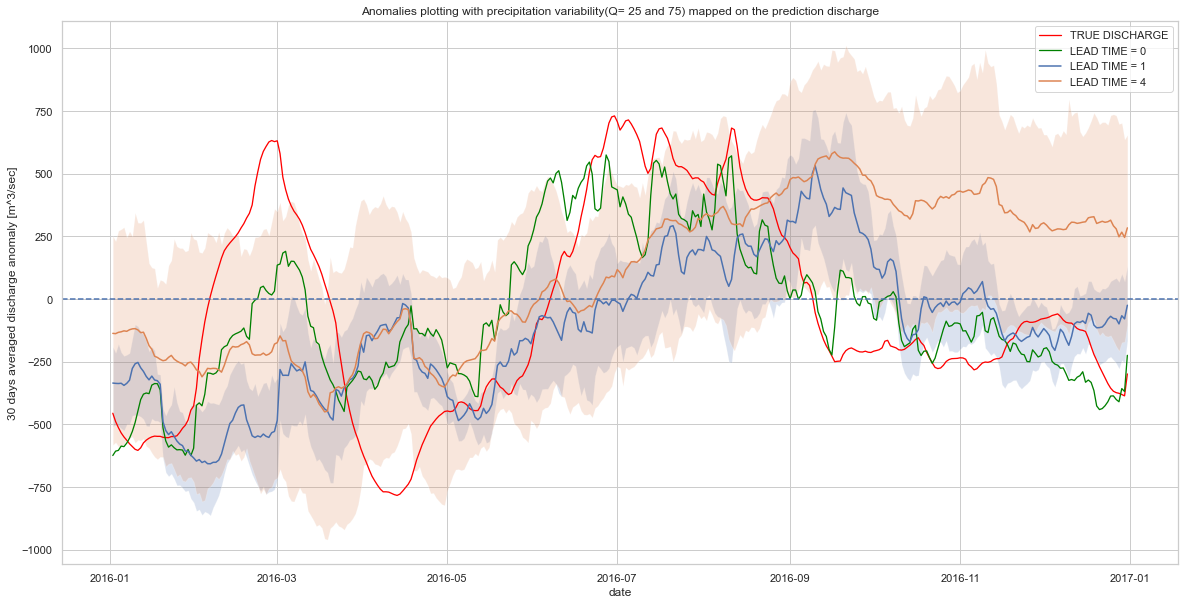

In [71]:
a2=compute_anomalies(climatologies2, predictions2)
a2['split']=predictions2.split

plot_anomalies(a2)

## C) NO_EVAP, T_UNIT = 30

In [73]:
daily_input_stat3 = daily_input_stat.drop(columns=[c for c in daily_input_stat.columns if c[0]=='E'])


Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits

C3=0.31622776601683794
eps3=1e-05


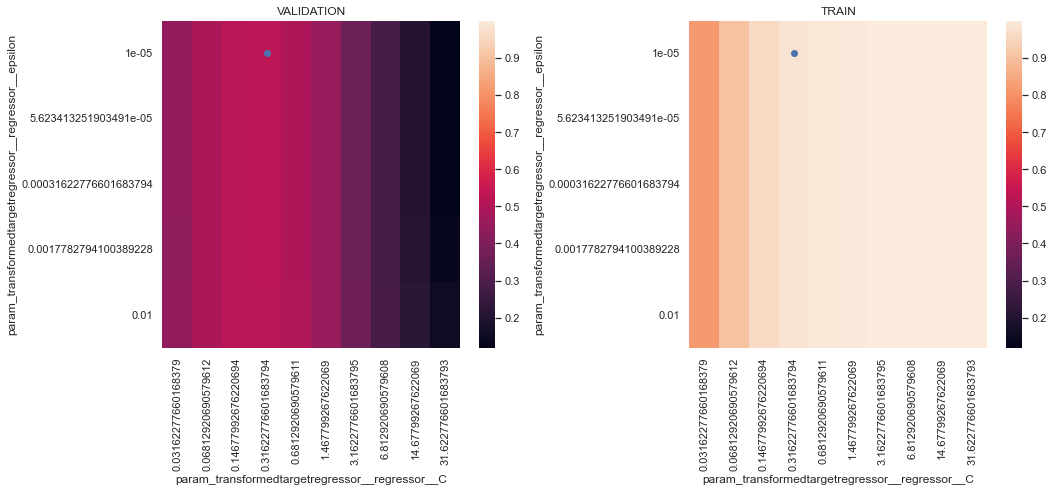

In [74]:
C3, eps3 = SVR_nested_CV_gridsearch(daily_input_stat3, C_range, epsilon_range, t_range, t_unit, n_splits, test_size)
print(f'C3={C3}')
print(f'eps3={eps3}')

In [75]:
C3=0.17782794100
eps3=0.316227766016

### PREDICT RUNOFF ON TEST SET AND QUANTIFY THE PERFORMANCE

In [76]:
radius_for_ensemble = 1
predictions3 = nested_CV_SVR_predict(daily_input_stat3, C3, eps3, t_length, t_unit, n_splits, test_size, radius_for_ensemble)

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

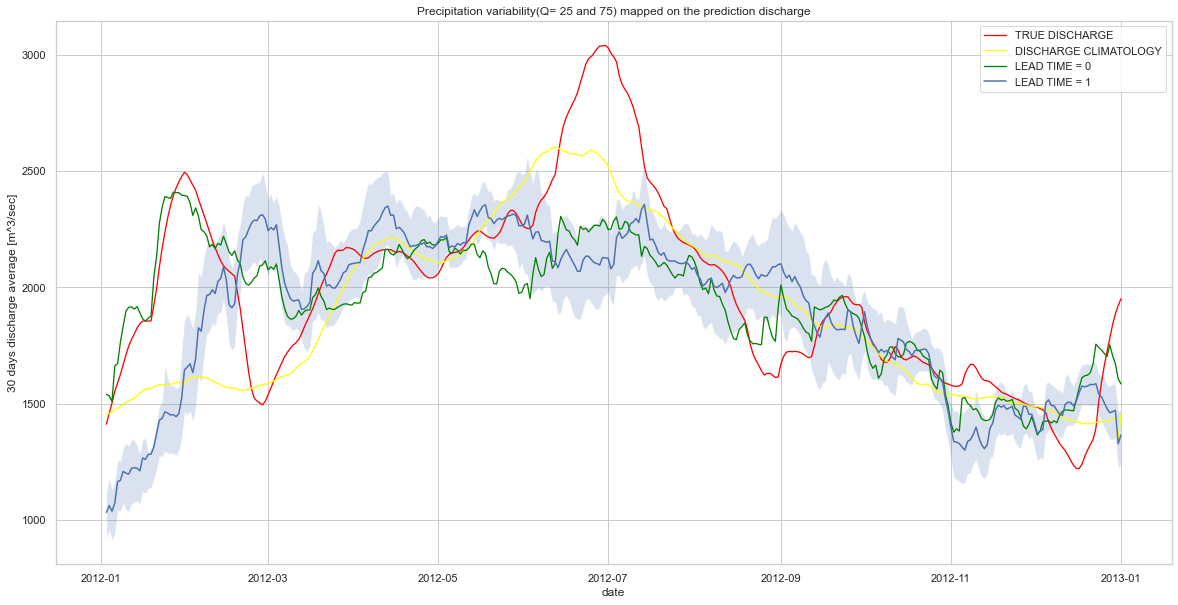

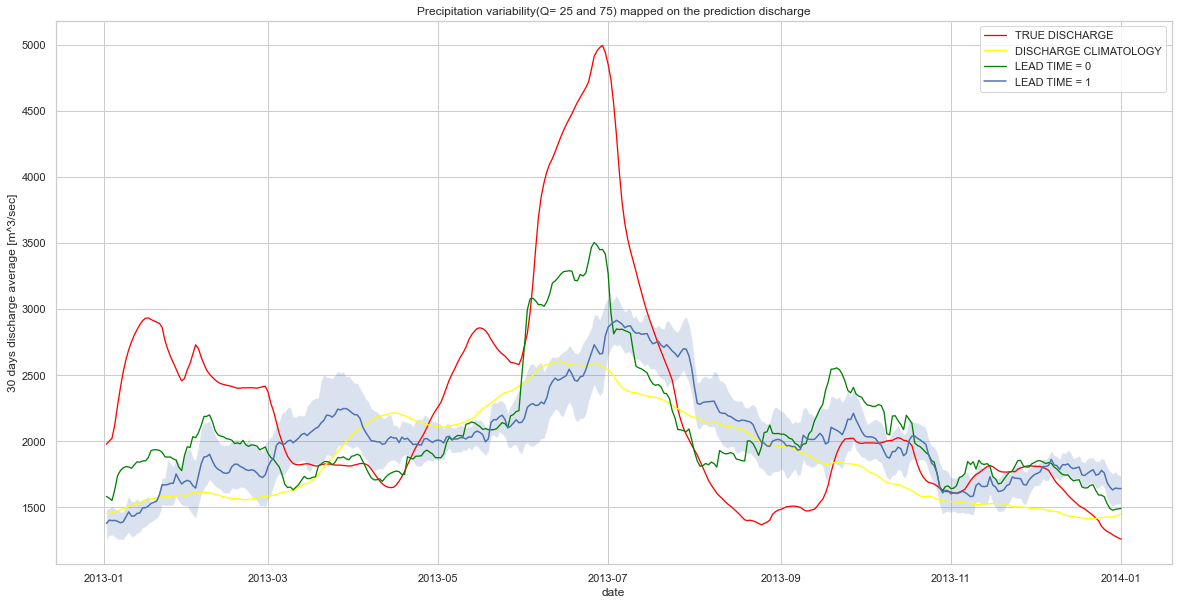

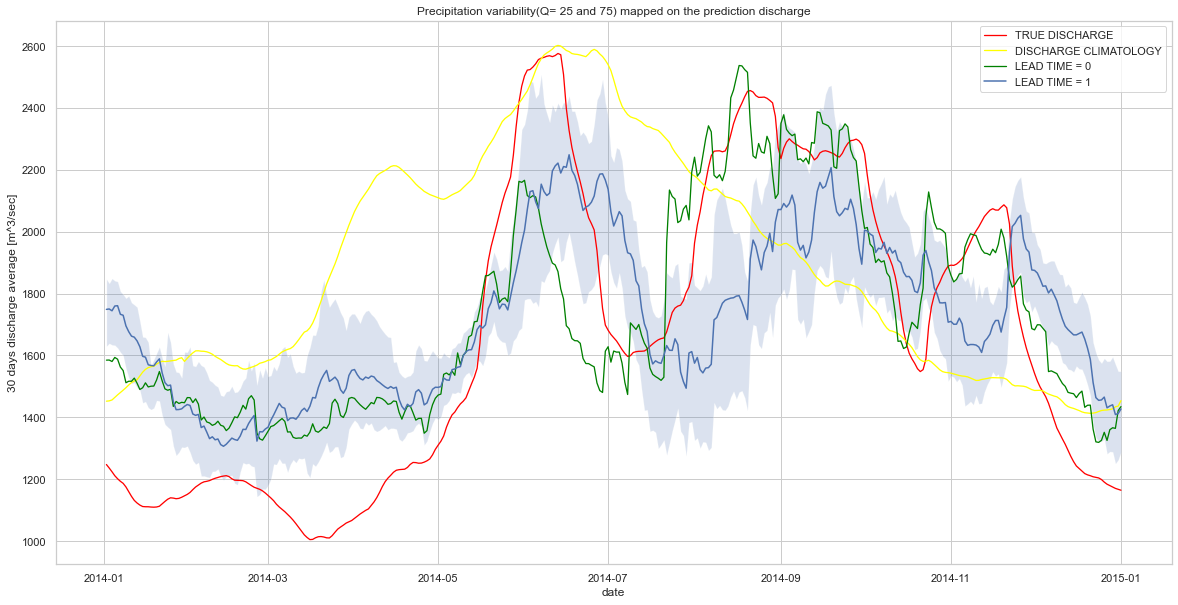

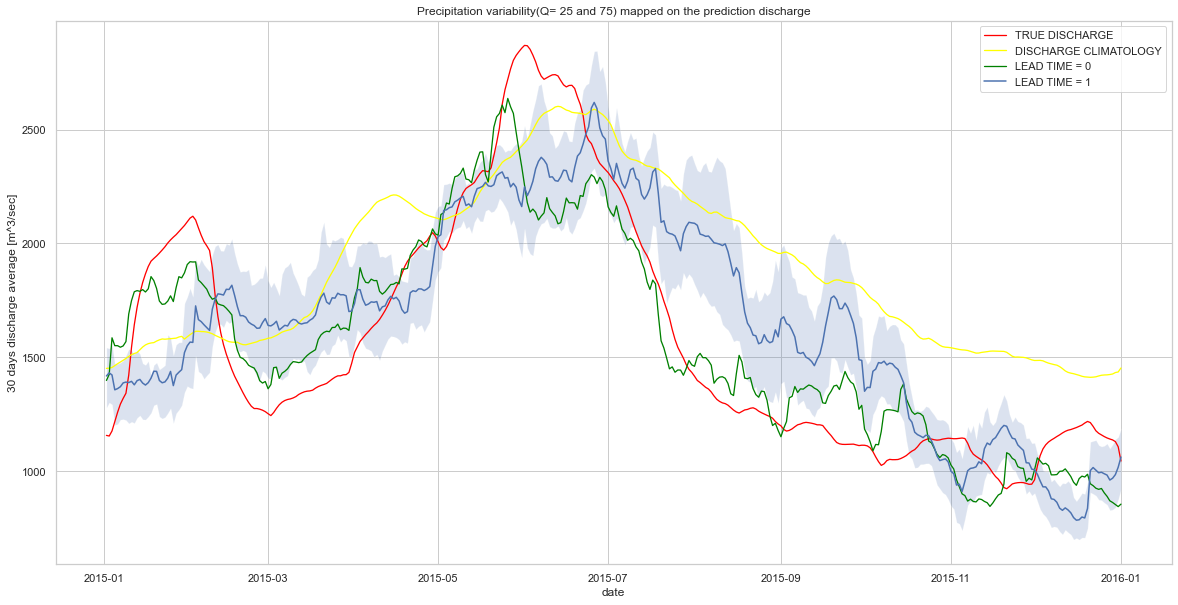

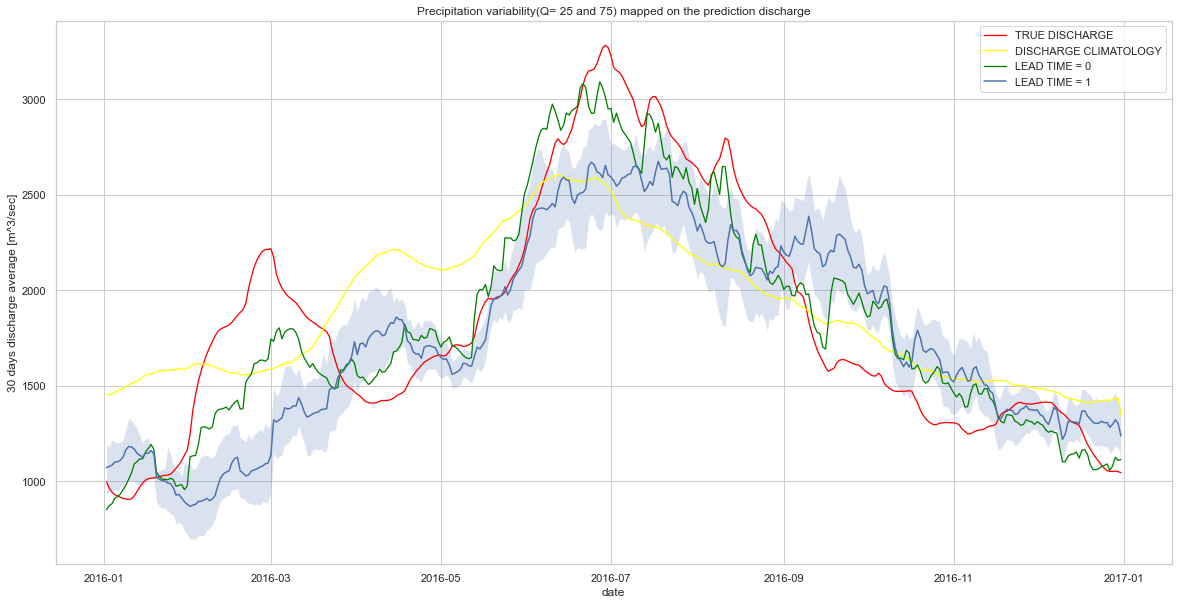

In [77]:
#predictions=pd.read_csv('tial.csv',date_parser=True)
plot_prediction(predictions3)

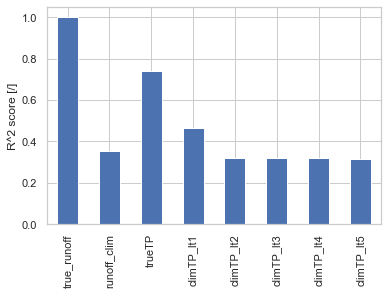

In [78]:
r2_C= evaluate_prediction(predictions3)

### ANALYSE RESULTS AS ANOMALIES

### 1) PREDICT THE WHOLE SERIES WITH CLASSIC CV

In [79]:
predictions_for_clim3 = classic_CV_SVR_predict(daily_input_stat3, C3, eps3, t_length, t_unit, n_splits)

In [80]:
climatologies3 =predictions_for_clim3.groupby(by=predictions_for_clim3.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies3['doty']=climatologies3.index


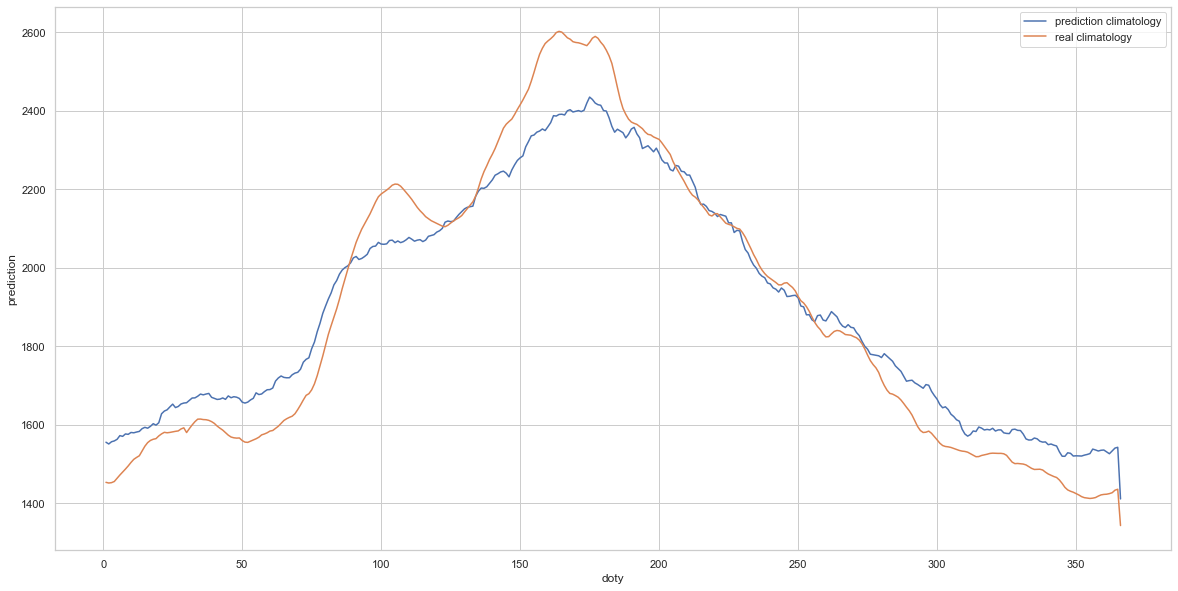

In [81]:
sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies3,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies3,x='doty',y='true_runoff',label='real climatology')
plt.legend()

### 2) COMPUTE THE ANOMALIES AND PLOT THEM

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

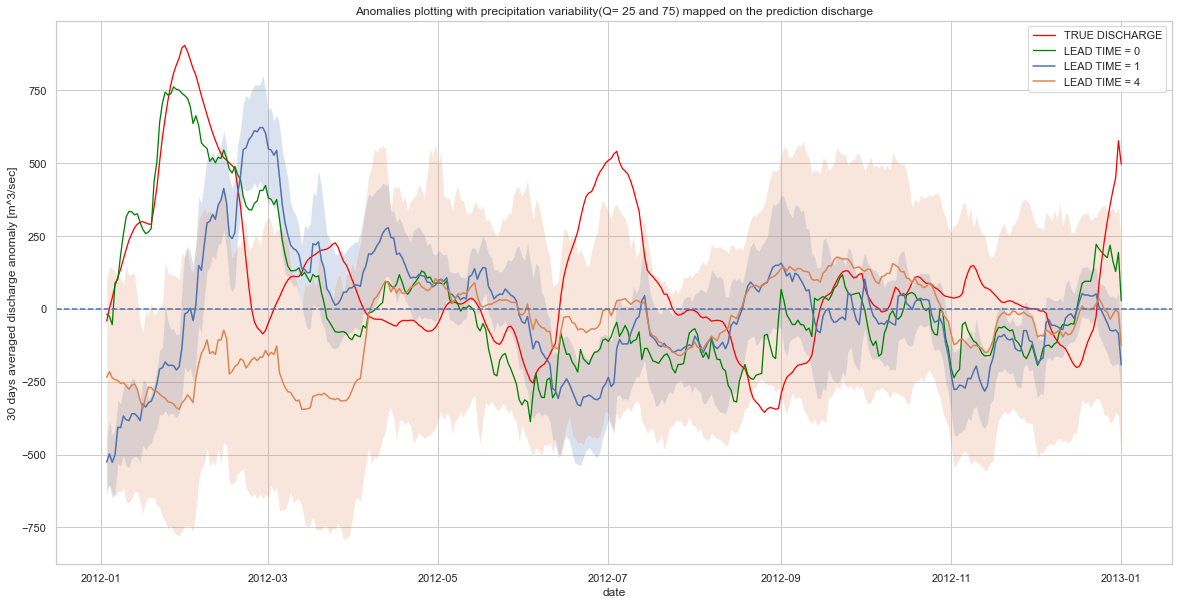

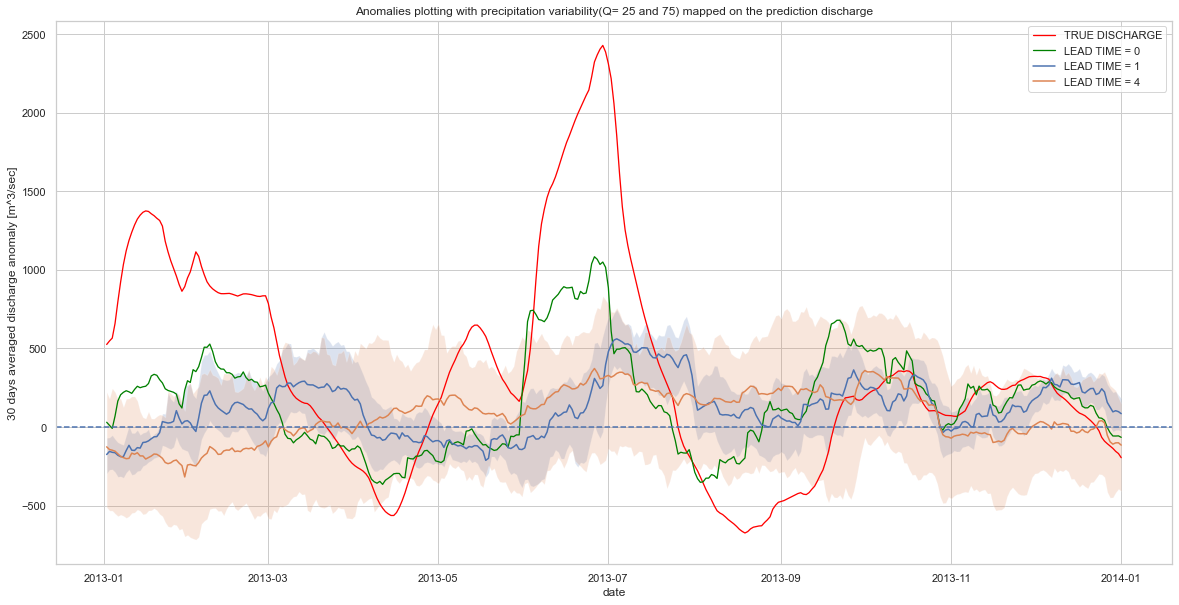

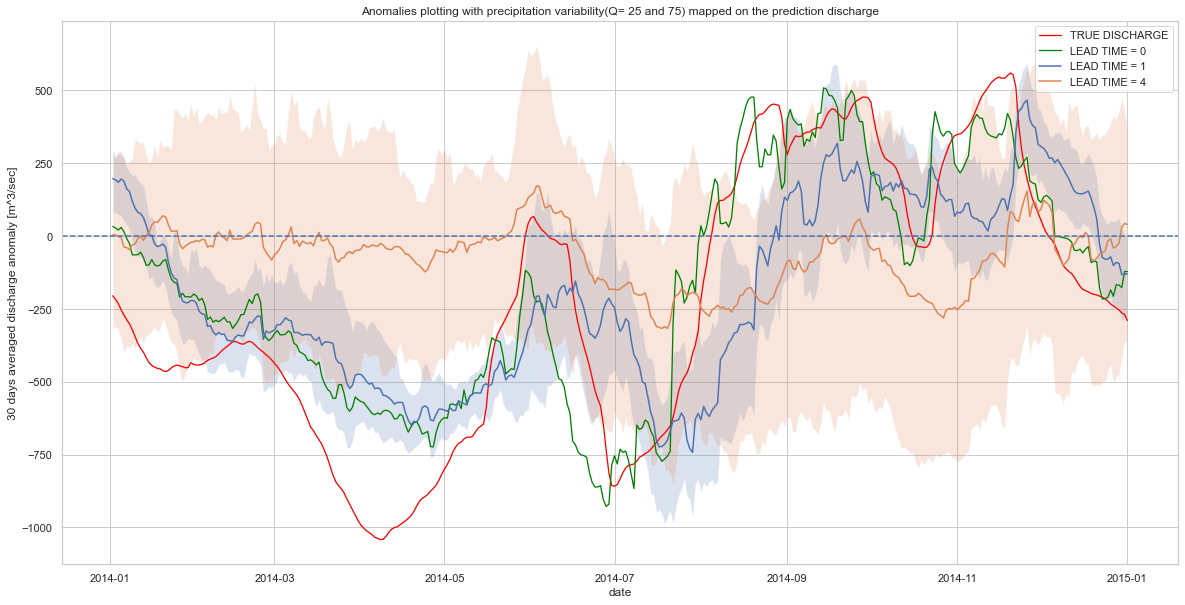

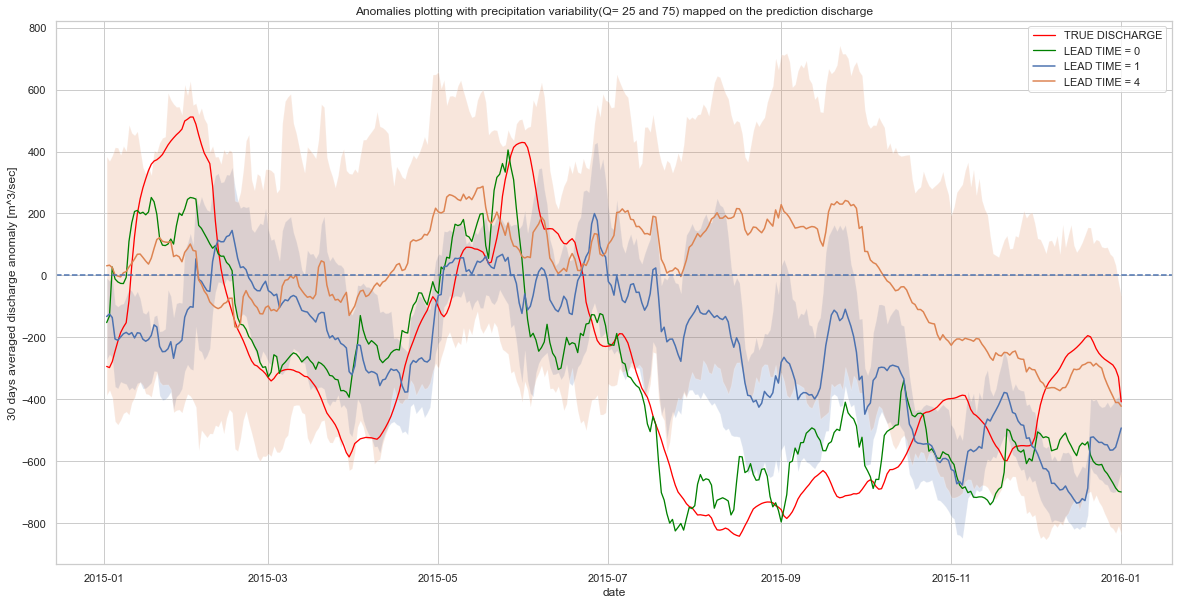

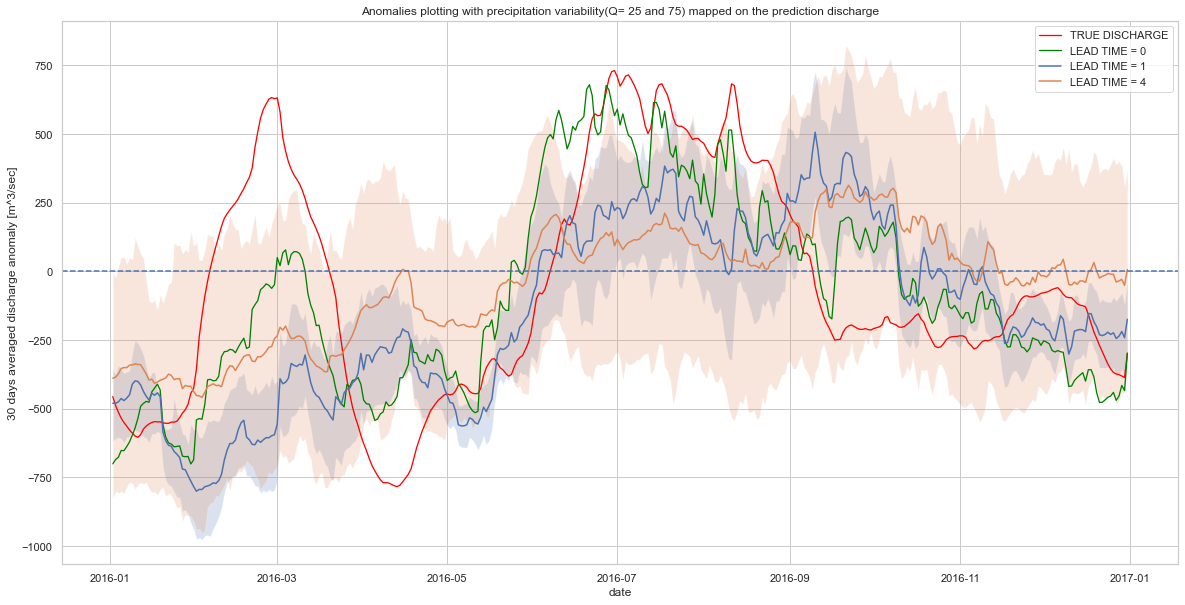

In [82]:
a3=compute_anomalies(climatologies3, predictions3)
a3['split']=predictions3.split

plot_anomalies(a3)

# COMPARE RESULTS

Text(0, 0.5, 'r^2 [/]')

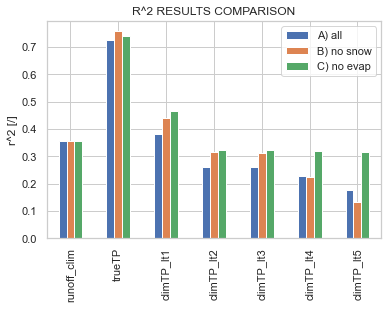

In [83]:
results = pd.concat([r2_A,r2_B,r2_C],axis=1)
results.columns=['A) all','B) no snow','C) no evap']
results.iloc[1:].plot.bar()
plt.title('R^2 RESULTS COMPARISON')
plt.ylabel('r^2 [/]')

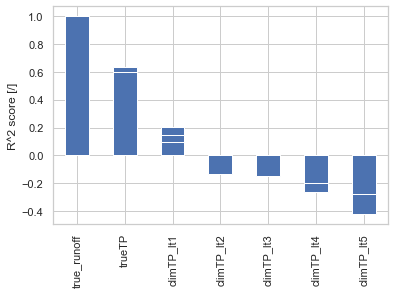

In [84]:
r2_a_C= evaluate_prediction(a3)
r2_a_B = evaluate_prediction(a2)
r2_a_A = evaluate_prediction(a)

Text(0.5, 1.0, 'R^2 RESULTS COMPARISON')

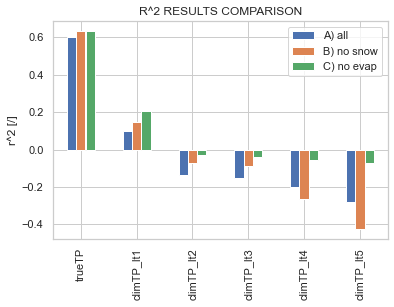

In [85]:
results_a = pd.concat([r2_a_A,r2_a_B,r2_a_C],axis=1)
results_a.columns=['A) all','B) no snow','C) no evap']
results_a.iloc[1:].plot.bar()
plt.ylabel('r^2 [/]')
plt.title('R^2 RESULTS COMPARISON')


In [86]:
results

A) all  B) no snow  C) no evap
true_runoff  1.000000    1.000000    1.000000
runoff_clim  0.356109    0.356109    0.356109
trueTP       0.723593    0.757378    0.738442
climTP_lt1   0.381308    0.438846    0.464124
climTP_lt2   0.259604    0.315313    0.322019
climTP_lt3   0.260491    0.313160    0.322327
climTP_lt4   0.227957    0.223743    0.318526
climTP_lt5   0.177394    0.131288    0.313955

In [87]:
arrays = [[np.array(np.repeat((t_unit),8),dtype=object),np.array(results.index)]]
tup=np.concatenate(arrays)
index = pd.MultiIndex.from_arrays(tup, names=["t_unit" , "lt"])

results.index=index

results


A) all  B) no snow  C) no evap
t_unit lt                                           
30     true_runoff  1.000000    1.000000    1.000000
       runoff_clim  0.356109    0.356109    0.356109
       trueTP       0.723593    0.757378    0.738442
       climTP_lt1   0.381308    0.438846    0.464124
       climTP_lt2   0.259604    0.315313    0.322019
       climTP_lt3   0.260491    0.313160    0.322327
       climTP_lt4   0.227957    0.223743    0.318526
       climTP_lt5   0.177394    0.131288    0.313955

In [88]:
arrays = [[np.array(np.repeat((t_unit),7),dtype=object),np.array(results_a.index)]]
tup=np.concatenate(arrays)
index = pd.MultiIndex.from_arrays(tup, names=["t_unit" , "lt"])

results_a.index=index

results_a

A) all  B) no snow  C) no evap
t_unit lt                                           
30     true_runoff  1.000000    1.000000    1.000000
       trueTP       0.600803    0.633542    0.631607
       climTP_lt1   0.096760    0.146725    0.204877
       climTP_lt2  -0.135769   -0.071668   -0.027820
       climTP_lt3  -0.150952   -0.089310   -0.037885
       climTP_lt4  -0.198945   -0.262618   -0.053314
       climTP_lt5  -0.280077   -0.422893   -0.071168

In [89]:
results.to_csv('results/DONAU_K__30.csv')
results_a.to_csv('results/DONAU_K__30_a.csv')

In [50]:
daily_input[360:]

Q      Tx12y0      Tx13y0      Tx12y1      Tx13y1  \
1995-12-27     NaN  264.621061  265.352377  263.095959  262.073419   
1995-12-28     NaN  258.637410  258.616214  257.109565  255.055287   
1995-12-29     NaN  259.888295  260.029861  258.756733  256.386464   
1995-12-30     NaN  262.728570  262.793761  261.629062  259.954827   
1995-12-31     NaN  268.030960  268.708255  267.448814  266.602353   
...            ...         ...         ...         ...         ...   
2016-12-28  1187.0  268.781284  269.428337  267.203173  266.440240   
2016-12-29  1226.0  268.108170  268.822157  266.828895  265.958840   
2016-12-30  1113.0  268.943104  269.757645  267.553337  266.967334   
2016-12-31  1009.0  268.383647  269.098787  267.023334  266.362991   
2017-01-01     NaN  267.993569  268.804995  266.950355  266.263257   

                Tx14y1      Tx15y1      Tx16y1      Tx11y2      Tx12y2  ...  \
1995-12-27  259.971825  259.829204  264.317727  262.742631  261.782656  ...   
1995-12-28  252.024614  252.356480  257.731588  257.252176  255.586166  ...   
1995-12-29  253.325564  253.491258  258.841635  258.929075  257.374910  ...   
1995-12-30  256.729275  256.515268  261.615737  261.971544  260.630921  ...   
1995-12-31  263.860682  263.166689  267.500247  267.658645  266.908424  ...   
...                ...         ...         ...         ...         ...  ...   
2016-12-28  263.763030  263.164010  267.466411  267.210948  266.339648  ...   
2016-12-29  263.298430  262.859258  267.457771  266.768832  265.751836  ...   
2016-12-30  264.439415  264.063289  268.355397  267.366006  266.640423  ...   
2016-12-31  263.833343  263.448418  268.041282  266.803702  266.040766  ...   
2017-01-01  263.558976  263.245110  267.696978  266.589937  265.939066  ...   

            Sx42y74  Sx43y74  Sx44y74  Sx45y74  Sx37y75  Sx38y75  Sx39y75  \
1995-12-27     19.0     12.0     11.0     21.0     44.0     61.0     41.0   
1995-12-28     19.0     12.0     11.0     21.0     44.0     61.0     41.0   
1995-12-29     19.0     12.0     11.0     21.0     44.0     61.0     41.0   
1995-12-30     19.0     12.0     11.0     21.0     45.0     61.0     41.0   
1995-12-31     19.0     12.0     11.0     21.0     45.0     61.0     41.0   
...             ...      ...      ...      ...      ...      ...      ...   
2016-12-28      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2016-12-29      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2016-12-30      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2016-12-31      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2017-01-01      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

            Sx40y75  Sx38y76  Sx39y76  
1995-12-27     28.0     66.0     41.0  
1995-12-28     28.0     66.0     41.0  
1995-12-29     28.0     66.0     41.0  
1995-12-30     28.0     67.0     41.0  
1995-12-31     27.0     67.0     41.0  
...             ...      ...      ...  
2016-12-28      0.0      0.0      0.0  
2016-12-29      0.0      0.0      0.0  
2016-12-30      0.0      0.0      0.0  
2016-12-31      0.0      0.0      0.0  
2017-01-01      0.0      0.0      0.0  

[7677 rows x 13689 columns]